# Dense Model


## Section for Configurations and Imports

In [1]:
import os 
import tempfile

import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from tensorflow import keras

# MLflow dashboard
import mlflow
mlflow.set_tracking_uri('http://35.228.45.76:5000')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='../../keys/mlflow-312506-8cfad529f4fd.json'

# Import data augmentation
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from augmentation.methods import *

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
random_state = 47
np.random.seed(random_state)

In [4]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

# 1. Data Preparation

## 1. Load Prepared Dataset

In [5]:
data_path = '../../datasets/'
files = [
    'posenet_scored_all_1.csv',
    'posenet_scored_all_2.csv',
    'posenet_scored_all_3.csv',
    'posenet_scored_all_4.csv',
]
df = None

In [6]:
import pandas as pd
for file in files:
    try:
        dataset = pd.read_csv(data_path + file)
        dataset.drop(columns=['left_eye_x', 'left_eye_y', 'left_eye_score', 'right_eye_x', 'right_eye_y', 'right_eye_score', 
                                'left_ear_x', 'left_ear_y', 'left_ear_score', 'right_ear_x', 'right_ear_y', 'right_ear_score'],
                                inplace=True)
        dataset.rename(columns = {'nose_x': 'head_x', 'nose_y': 'head_y', 'nose_score': 'head_score'}, inplace = True)
        if df is None:
            df = dataset
        else:
            df = df.append(dataset, ignore_index=True)  
    except IOError as e:
        print('Error in reading file: ', e)
print(df.shape)
print(df.head())

(225092, 42)
       head_x     head_y  head_score  left_shoulder_x  left_shoulder_y  \
0  421.555422  91.446746    0.995605       397.484966       131.001872   
1  421.555422  91.446746    0.995605       397.484966       131.001872   
2  421.555422  91.446746    0.995605       397.484966       131.001872   
3  421.555422  91.446746    0.995605       397.484966       131.001872   
4  421.555422  91.446746    0.995605       397.484966       131.001872   

   left_shoulder_score  right_shoulder_x  right_shoulder_y  \
0             0.998238        461.732625        132.726183   
1             0.998238        461.732625        132.726183   
2             0.998238        461.732625        132.726183   
3             0.998238        461.732625        132.726183   
4             0.998238        461.732625        132.726183   

   right_shoulder_score  left_elbow_x  ...  right_knee_score  left_ankle_x  \
0              0.999635    376.969123  ...          0.999779    416.909581   
1            

## 2. Split

In [7]:
X = df.drop(columns=['ConfidenceScore', 'GoodnessScore'])
y = df[['ConfidenceScore', 'GoodnessScore']]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

In [9]:
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')
print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training features shape: (202582, 40)
Training labels shape: (202582, 2) 

Test features shape: (22510, 40)
Test labels shape: (22510, 2)


## 3. Define the Model

### 3.1 Configurations

In [10]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten

EPOCHS = 500
BATCH_SIZE = 150

input_dim = X_train.shape[1]
output_size = 2

units = 64
activation = 'relu'
#kernel_initializer = 'he_uniform'
kernel_initializer = 'normal'
#output_activation = 'sigmoid'
#output_activation = 'sigmoid'
output_activation = 'linear'
#optimizer = 'SGD'
#optimizer = 'RMSprop'
optimizer = 'Adam'
learning_rate = 1e-3

### 3.2 Model Architecture

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

#METRICS = [
#    keras.metrics.MeanSquaredError(name="mean_squared_error"),
#    keras.metrics.RootMeanSquaredError(name="root_mean_squared_error"),
#    keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
#    keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error"),
#]

from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError


METRICS = [
    MeanSquaredError(name="mse", dtype=None),
    MeanAbsoluteError(name="mae", dtype=None),
    RootMeanSquaredError(name="rmse", dtype=None),
]

def make_model(input_dim, loss, optimizer, learning_rate=0.001, metrics=METRICS):
    #MODEL 3 - Champ
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(output_size, activation=output_activation))
    #http://35.228.45.76:5000/#/experiments/0/runs/0b6786ed5d8f4860a817b4d514aa4de5
    
    #MODEL 2
    #model.add(Dense(128, input_dim=input_dim, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(32, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(8, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(output_size, activation=output_activation))
    #http://35.228.45.76:5000/#/experiments/0/runs/12172f32a5d64cbfbd906c9d486cb90e
    
    #MODEL 1
    #model.add(Dense(64, input_dim=input_dim, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(32, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(8, kernel_initializer=kernel_initializer, activation=activation))
    #model.add(Dense(output_size, activation=output_activation))
    #http://35.228.45.76:5000/#/experiments/0/runs/b7f73a3ba8944e139b5280c0e13cf505
    
    
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate.assign(learning_rate)

    model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

    print(model.summary())

    return model

## 4. MLflow Experimentation

### 4.1 Configurations

In [12]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec
input_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "head_score"),
    ColSpec("double", "left_shoulder_x"),
    ColSpec("double", "left_shoulder_y"),
    ColSpec("double", "left_shoulder_score"),
    ColSpec("double", "right_shoulder_x"),
    ColSpec("double", "right_shoulder_y"),
    ColSpec("double", "right_shoulder_score"),
    ColSpec("double", "left_elbow_x"),
    ColSpec("double", "left_elbow_y"),
    ColSpec("double", "left_elbow_score"),
    ColSpec("double", "right_elbow_x"),
    ColSpec("double", "right_elbow_y"),
    ColSpec("double", "right_elbow_score"),
    ColSpec("double", "left_wrist_x"),
    ColSpec("double", "left_wrist_y"),
    ColSpec("double", "left_wrist_score"),
    ColSpec("double", "right_wrist_x"),
    ColSpec("double", "right_wrist_y"),
    ColSpec("double", "right_wrist_score"),
    ColSpec("double", "left_hip_x"),
    ColSpec("double", "left_hip_y"),
    ColSpec("double", "left_hip_score"),
    ColSpec("double", "right_hip_x"),
    ColSpec("double", "right_hip_y"),
    ColSpec("double", "right_hip_score"),
    ColSpec("double", "left_knee_x"),
    ColSpec("double", "left_knee_y"),
    ColSpec("double", "left_knee_score"),
    ColSpec("double", "right_knee_x"),
    ColSpec("double", "right_knee_y"),
    ColSpec("double", "right_knee_score"),
    ColSpec("double", "left_ankle_x"),
    ColSpec("double", "left_ankle_y"),
    ColSpec("double", "left_ankle_score"),
    ColSpec("double", "right_ankle_x"),
    ColSpec("double", "right_ankle_y"),
    ColSpec("double", "right_ankle_score"),
    ColSpec("double", "score")
])
output_schema = Schema([
    ColSpec("double", "ConfidenceScore"),
    ColSpec("double", "GoodnessScore"),
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

### 4.2 Helper functions

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

def eval_metrics(actual, pred):
    mse = mean_squared_error(actual, pred)
    msa = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    variance = explained_variance_score(actual, pred)
    return mse, msa, r2, variance

### 4.3 Start Run

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5248      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 17,794
Trainable params: 17,794
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
1081/1081 - 1s - loss: 0.8422 - mse: 0.8422 - mae: 0.7063 - rmse: 0.9177 - val_loss: 0.6626 - val_mse: 0.6626 - val_mae: 0.6486 - val_rmse: 0.8140
Epoch 2/500
1081/1081 - 1s - loss: 0.6096 - mse: 0.6096 - mae: 0.6145 - rmse: 0.7808 -

Epoch 47/500
1081/1081 - 1s - loss: 0.3173 - mse: 0.3173 - mae: 0.3349 - rmse: 0.5633 - val_loss: 0.3157 - val_mse: 0.3157 - val_mae: 0.3342 - val_rmse: 0.5619
Epoch 48/500
1081/1081 - 1s - loss: 0.3153 - mse: 0.3153 - mae: 0.3335 - rmse: 0.5615 - val_loss: 0.3136 - val_mse: 0.3136 - val_mae: 0.3325 - val_rmse: 0.5600
Epoch 49/500
1081/1081 - 1s - loss: 0.3133 - mse: 0.3133 - mae: 0.3320 - rmse: 0.5597 - val_loss: 0.3117 - val_mse: 0.3117 - val_mae: 0.3305 - val_rmse: 0.5583
Epoch 50/500
1081/1081 - 1s - loss: 0.3113 - mse: 0.3113 - mae: 0.3305 - rmse: 0.5579 - val_loss: 0.3096 - val_mse: 0.3096 - val_mae: 0.3293 - val_rmse: 0.5565
Epoch 51/500
1081/1081 - 1s - loss: 0.3093 - mse: 0.3093 - mae: 0.3291 - rmse: 0.5561 - val_loss: 0.3077 - val_mse: 0.3077 - val_mae: 0.3282 - val_rmse: 0.5547
Epoch 52/500
1081/1081 - 1s - loss: 0.3073 - mse: 0.3073 - mae: 0.3275 - rmse: 0.5543 - val_loss: 0.3058 - val_mse: 0.3058 - val_mae: 0.3272 - val_rmse: 0.5530
Epoch 53/500
1081/1081 - 1s - loss: 0.30

Epoch 99/500
1081/1081 - 1s - loss: 0.2287 - mse: 0.2287 - mae: 0.2753 - rmse: 0.4782 - val_loss: 0.2311 - val_mse: 0.2311 - val_mae: 0.2763 - val_rmse: 0.4808
Epoch 100/500
1081/1081 - 1s - loss: 0.2275 - mse: 0.2275 - mae: 0.2745 - rmse: 0.4770 - val_loss: 0.2290 - val_mse: 0.2290 - val_mae: 0.2737 - val_rmse: 0.4785
Epoch 101/500
1081/1081 - 1s - loss: 0.2263 - mse: 0.2263 - mae: 0.2736 - rmse: 0.4757 - val_loss: 0.2268 - val_mse: 0.2268 - val_mae: 0.2736 - val_rmse: 0.4762
Epoch 102/500
1081/1081 - 1s - loss: 0.2251 - mse: 0.2251 - mae: 0.2728 - rmse: 0.4744 - val_loss: 0.2294 - val_mse: 0.2294 - val_mae: 0.2778 - val_rmse: 0.4790
Epoch 103/500
1081/1081 - 1s - loss: 0.2239 - mse: 0.2239 - mae: 0.2721 - rmse: 0.4732 - val_loss: 0.2268 - val_mse: 0.2268 - val_mae: 0.2740 - val_rmse: 0.4762
Epoch 104/500
1081/1081 - 1s - loss: 0.2227 - mse: 0.2227 - mae: 0.2713 - rmse: 0.4719 - val_loss: 0.2239 - val_mse: 0.2239 - val_mae: 0.2721 - val_rmse: 0.4732
Epoch 105/500
1081/1081 - 1s - loss

Epoch 150/500
1081/1081 - 1s - loss: 0.1825 - mse: 0.1825 - mae: 0.2432 - rmse: 0.4272 - val_loss: 0.1856 - val_mse: 0.1856 - val_mae: 0.2428 - val_rmse: 0.4308
Epoch 151/500
1081/1081 - 1s - loss: 0.1817 - mse: 0.1817 - mae: 0.2427 - rmse: 0.4263 - val_loss: 0.1866 - val_mse: 0.1866 - val_mae: 0.2473 - val_rmse: 0.4320
Epoch 152/500
1081/1081 - 1s - loss: 0.1813 - mse: 0.1813 - mae: 0.2423 - rmse: 0.4258 - val_loss: 0.1825 - val_mse: 0.1825 - val_mae: 0.2434 - val_rmse: 0.4272
Epoch 153/500
1081/1081 - 1s - loss: 0.1807 - mse: 0.1807 - mae: 0.2418 - rmse: 0.4251 - val_loss: 0.1844 - val_mse: 0.1844 - val_mae: 0.2443 - val_rmse: 0.4295
Epoch 154/500
1081/1081 - 1s - loss: 0.1800 - mse: 0.1800 - mae: 0.2413 - rmse: 0.4243 - val_loss: 0.1811 - val_mse: 0.1811 - val_mae: 0.2422 - val_rmse: 0.4255
Epoch 155/500
1081/1081 - 1s - loss: 0.1795 - mse: 0.1795 - mae: 0.2410 - rmse: 0.4236 - val_loss: 0.1809 - val_mse: 0.1809 - val_mae: 0.2416 - val_rmse: 0.4253
Epoch 156/500
1081/1081 - 1s - los

Epoch 201/500
1081/1081 - 1s - loss: 0.1583 - mse: 0.1583 - mae: 0.2248 - rmse: 0.3979 - val_loss: 0.1627 - val_mse: 0.1627 - val_mae: 0.2276 - val_rmse: 0.4033
Epoch 202/500
1081/1081 - 1s - loss: 0.1581 - mse: 0.1581 - mae: 0.2246 - rmse: 0.3976 - val_loss: 0.1591 - val_mse: 0.1591 - val_mae: 0.2238 - val_rmse: 0.3988
Epoch 203/500
1081/1081 - 1s - loss: 0.1578 - mse: 0.1578 - mae: 0.2244 - rmse: 0.3972 - val_loss: 0.1604 - val_mse: 0.1604 - val_mae: 0.2245 - val_rmse: 0.4005
Epoch 204/500
1081/1081 - 1s - loss: 0.1573 - mse: 0.1573 - mae: 0.2240 - rmse: 0.3966 - val_loss: 0.1636 - val_mse: 0.1636 - val_mae: 0.2295 - val_rmse: 0.4044
Epoch 205/500
1081/1081 - 1s - loss: 0.1569 - mse: 0.1569 - mae: 0.2237 - rmse: 0.3961 - val_loss: 0.1619 - val_mse: 0.1619 - val_mae: 0.2256 - val_rmse: 0.4023
Epoch 206/500
1081/1081 - 1s - loss: 0.1567 - mse: 0.1567 - mae: 0.2236 - rmse: 0.3958 - val_loss: 0.1626 - val_mse: 0.1626 - val_mae: 0.2256 - val_rmse: 0.4033
Epoch 207/500
1081/1081 - 1s - los

Epoch 252/500
1081/1081 - 1s - loss: 0.1439 - mse: 0.1439 - mae: 0.2133 - rmse: 0.3793 - val_loss: 0.1568 - val_mse: 0.1568 - val_mae: 0.2211 - val_rmse: 0.3960
Epoch 253/500
1081/1081 - 1s - loss: 0.1434 - mse: 0.1434 - mae: 0.2130 - rmse: 0.3786 - val_loss: 0.1457 - val_mse: 0.1457 - val_mae: 0.2133 - val_rmse: 0.3817
Epoch 254/500
1081/1081 - 1s - loss: 0.1435 - mse: 0.1435 - mae: 0.2129 - rmse: 0.3788 - val_loss: 0.1689 - val_mse: 0.1689 - val_mae: 0.2344 - val_rmse: 0.4110
Epoch 255/500
1081/1081 - 1s - loss: 0.1430 - mse: 0.1430 - mae: 0.2127 - rmse: 0.3782 - val_loss: 0.1503 - val_mse: 0.1503 - val_mae: 0.2163 - val_rmse: 0.3876
Epoch 256/500
1081/1081 - 1s - loss: 0.1426 - mse: 0.1426 - mae: 0.2122 - rmse: 0.3777 - val_loss: 0.1480 - val_mse: 0.1480 - val_mae: 0.2156 - val_rmse: 0.3847
Epoch 257/500
1081/1081 - 1s - loss: 0.1427 - mse: 0.1427 - mae: 0.2122 - rmse: 0.3777 - val_loss: 0.1542 - val_mse: 0.1542 - val_mae: 0.2213 - val_rmse: 0.3927
Epoch 258/500
1081/1081 - 1s - los

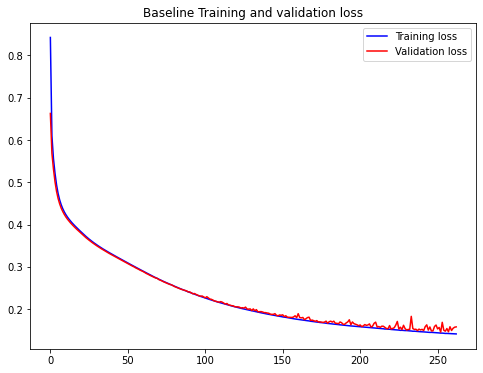

<Figure size 576x432 with 0 Axes>

INFO:tensorflow:Assets written to: /var/folders/8b/c37c7tv54lg10kt29r67dkh80000gn/T/tmpjjnxcjry/model/data/model/assets
MSE:  0.15342943030224623
MAE:  0.20465486244847644
R-Squared:  0.850949506087348
Explained Variance Score:  0.8516390125874547


In [15]:
model_name = 'dense_model_confidence_goodness'
#binary_crossentropy
with mlflow.start_run(run_name=model_name) as run:

    run_id = run.info.run_id

    model = make_model(metrics=METRICS, 
                        loss='mean_squared_error', 
                        optimizer=optimizer, 
                        learning_rate=learning_rate, 
                        input_dim=input_dim)
    
    with tf.device('/CPU:0'):
        history = model.fit(
            x=X_train, 
            y=y_train, 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=2,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping])

        # Plot training history
    plot_train_history(history, 'Baseline Training and validation loss')
    plt.savefig("training_history.jpg")
    mlflow.log_artifact("training_history.jpg")
    plt.show()

    # Log model parameters
    mlflow.log_param("activation", activation)
    mlflow.log_param("kernel initializer", kernel_initializer)
    mlflow.log_param("output activation", output_activation)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("learning rate", learning_rate)
    mlflow.log_param("batch size", BATCH_SIZE)
    mlflow.log_param("epochs", early_stopping.stopped_epoch)

    # Log model performance
    process_time = [None] * 10
    
    for i in range(10):
        start_time = time.time()
        predictions = model.predict(X_test)
        end_time = time.time()
        process_time[i] = (end_time - start_time) * 1000
    
    predictions = y_scaler.inverse_transform(predictions)
    (mse, mae, r2, variance) = eval_metrics(y_test, predictions)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("R-squared", r2)
    mlflow.log_metric("variance", variance)
    mlflow.log_param("total params", model.count_params())
    mlflow.log_metric("process time", np.mean(process_time)) 

    # Log model and scaler(s)
    mlflow.keras.log_model(model, model_name, signature=signature)
    mlflow.sklearn.log_model(X_scaler, 'InputScaler')
    mlflow.sklearn.log_model(y_scaler, 'OutputScaler')
    
    # Print metrics
    print('MSE: ', mse)
    print('MAE: ', mae)
    print('R-Squared: ', r2)
    print('Explained Variance Score: ', variance)

## 5. Register Model

In [16]:
model_uri = "runs:/{}/{}".format(run.info.run_id, model_name)
mv = mlflow.register_model(model_uri, model_name)
print("Name: {}".format(mv.name))
print("Version: {}".format(mv.version))

Registered model 'dense_model_confidence_goodness' already exists. Creating a new version of this model...
2021/05/25 20:32:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: dense_model_confidence_goodness, version 22


Name: dense_model_confidence_goodness
Version: 22


Created version '22' of model 'dense_model_confidence_goodness'.
